# Analysing Topical Shifts in Migration Publication via Title Words

The titles of publications on migration management give us an overview of what the scientific community focused in their research over the decades.

The dataset consists of authors, titles and publication year of publications in the Research group on European Migration Problems series (REMP, since 1951), and the journals International Migration (IM, since 1964) and International Migration Review (IMR, since 1964), over the period 1951-2000. 

We use Content Analysis as a method to investigate topical shifts in the discourse around migration management. “Content analysis is an approach to the analysis of documents and texts (which may consist of words and/or images and may be printed or online, written or spoken) that seeks to quantify content in terms of predetermined categories and in a systematic and replicable manner.” (Bryman, 2016, p.283).

## Data Selection

Before performing a content analysis of the article titles, we want to make a selection of titles that is focused on the academic debate around migration, without any distracting non-topical titles that might obscure any topical shifts across the decades from 1951-2000.

Given the analysis above, we use the following three sets of articles for analysis:

1. main articles from REMP and IM, plus the IM review articles,
2. main articles from IMR
3. review articles from IMR

The reason to combine the main and review articles of IM is that the number of review articles is too low for independent content analysis. 

### References 

Bryman, A. (2016). Social research methods (Fifth edition.). Oxford ; New York: Oxford University Press.



In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd

# the name and location of the article records for the IM journal (in CSV format)
records_file = '../data/main-review-article-records.csv'

columns = ['article_title', 'issue_pub_year', 'publisher', 'article_type']
# load the csv data into a data frame
df = pd.read_csv(records_file, usecols=columns)
# show the first and last records of the dataset to demonstrate what the records look like
df.head(5)

,article_title,issue_pub_year,publisher,article_type
0,The importance of emigration for the solution ...,1951,Staatsdrukkerij,main
1,European emigration overseas past and future,1951,Staatsdrukkerij,main
2,Some aspects of migration problems in the Neth...,1952,Staatsdrukkerij,main
3,Some quantitative aspects of future population...,1952,Staatsdrukkerij,main
4,"The refugees as a burden, a stimulus, and a ch...",1951,Staatsdrukkerij,main


In [3]:
def map_dataset(publisher, article_type):
    # all REMP and IM (published by Wiley) articles are bunlded in a single dataset
    if publisher == 'Staatsdrukkerij' or publisher == 'Wiley':
        return 'REMP_IM'
    # The IMR articles are separated in review articles and research articles
    return 'IMR_research' if article_type == 'main' else 'IMR_review'

df['dataset'] = df.apply(lambda x: map_dataset(x['publisher'], x['article_type']), axis=1)
df.dataset.value_counts()

IMR_review      1842
IMR_research    1539
REMP_IM          901
Name: dataset, dtype: int64

### Analysing Title Words Per Decade

The articles are published over a period of several decades, and there might be shifts in the discourse over time. A next step is to group uni-grams and bi-grams per decade, to visualise shifts.

The first step is to group the article titles per decade. We derive the decade from the year that the issue was published. 

**TO DO: elaborate choice for per-decade.**

In [4]:
# adding a column per article with the publication decade
df['issue_decade'] = df.issue_pub_year.apply(lambda x: int(x/10) * 10 if not pd.isnull(x) else x)

df.issue_decade.value_counts()

1990    1490
1980    1236
1970    1052
1960     404
1950     100
Name: issue_decade, dtype: int64

In [5]:
df.groupby(['issue_decade', 'dataset']).size()

issue_decade  dataset     
1950          REMP_IM         100
1960          IMR_research    122
              IMR_review      129
              REMP_IM         153
1970          IMR_research    340
              IMR_review      592
              REMP_IM         120
1980          IMR_research    475
              IMR_review      519
              REMP_IM         242
1990          IMR_research    602
              IMR_review      602
              REMP_IM         286
dtype: int64

## Analysing Discourse Topics Through Publication Titles

The titles are at most only a highly condensed summary of the topics discussed in the publications, but nevertheless allows us to track what the debate focussed on and how attention shifted across the decades. 

We conduct a content analysis of the three sets of titles by comparing the frequencies of terms (e.g. individual words and common two-word phrases) across the datasets and across decades. Before counting terms, we normalise titles by removing punctuation, quote characters, superscript symbols for footnotes and stop words, then lowercasing all terms so that differences in case do not result in different terms.

In [6]:
import scripts.content_analysis as ca

# create a normalised version of the article title
# - remove footnote symbols, stopwords, punctuation and quote characters
# - standardise acronyms
# - remove 'Book Review: ' prefix from review article titles
df['normalised_title'] = df.article_title.apply(ca.normalise_title)
df.normalised_title

0       the importance of emigration for the solution ...
1            european emigration overseas past and future
2       some aspect of migration problem in the nether...
3       some quantitative aspect of future population ...
4       the refugee as a burden a stimulus and a chall...
                              ...                        
4277                                chapter four go north
4278               chapter five the new york labor market
4279                   chapter six the settlement process
4280                             chapter seven conclusion
4281                                         bibliography
Name: normalised_title, Length: 4282, dtype: object

### Bigrams

An additional transformation step we take is identifying and marking common two-collocations so that they are treated as single terms. That is, a collocation like _United States_  should not be treated as two words _United_ and _States_ but as a single term.

Below we transform titles that have common collocations by replacing the whitespace between collocated words with an underscore, so they become a single term.

In [7]:
from scripts.content_analysis import mark_bigrams, extract_bigrams

# Fetch a multilingual stopword list
stopwords = ca.get_stopwords()
# make a flat list of all the normalised titles
titles = list(df.normalised_title)
# extract bigrams from the titles, ignoring bigrams that contain stopwords
bigrams = extract_bigrams(titles, stopwords)
# add a new column based on the normalised titles, but with bigrams marked by an underscore
df['bigrammed_title'] = df.normalised_title.apply(lambda x: mark_bigrams(x, bigrams))
df.bigrammed_title.head(5)
#[bigram for bigram in bigrams if bigram[1] == 'problem']

0    the importance of emigration for the solution ...
1         european emigration overseas past and future
2    some aspect of migration_problem in the nether...
3    some quantitative aspect of future population ...
4    the refugee as a burden a stimulus and a chall...
Name: bigrammed_title, dtype: object

The third title has the collocation _migration_problems_. 


### From Terms to TF\*IDF

To compute TF\*IDF scores, we compute the TF and IDF parts separately on different representations of the titles:

- *IDF*: count the document frequencies and IDF of terms per title. This ensures that the IDF for a term is the same across the three datasets and across the decades, so that we can meaningfully interpret differences when comparing datasets and decades. 
- *TF*: the term frequency is computed on the aggregation of all titles per dataset, per decade. That is, we combine the titles for the publications in a single decade in a single dataset into a single document and count the frequency of each term.

We start with grouping publications titles per decade and dataset.

In [8]:
from collections import Counter
from collections import defaultdict

unigram_freq = defaultdict(dict)
grouped_titles = defaultdict(dict)

for decade in df.issue_decade.unique():
    for dataset in df.dataset.unique():
        titles = list(df[(df.issue_decade == decade) & (df.dataset == dataset)].bigrammed_title)
        grouped_titles[dataset][decade] = list(titles)


Next, we compute the IDF scores per term based on the individual titles as documents.

In [9]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer

stopwords = ca.get_stopwords()


# make a list of all the titles with identified bigrams.
docs = list(df.bigrammed_title)

# instantiate a CountVectorizer() 
cv=CountVectorizer(stop_words=stopwords, analyzer='word') 
 
# compute word counts per title
word_count_vector=cv.fit_transform(docs)
# instantiate a tf*idf transformer
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
# fit the word counts per title to the tf*idf transformer
tfidf_transformer.fit(word_count_vector)


# extract the IDF values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# show the term with lowest and highest IDF scores
df_idf.sort_values(by=['idf_weights'])

,idf_weights
migration,3.110505
immigrant,3.587857
united_states,3.829019
immigration,3.836956
american,4.059104
...,...
haveman,8.669262
hawau,8.669262
head,8.669262
happy,8.669262


Not surprisingly, terms like _migration_, _immigration_ and _immigrants_ have the lowest IDF scores as they are occur in more titles than other terms. Note that _united_states_ and _america_ also occur in many titles. 

The terms with the highest IDF scores are those that occur only in a single title.

If we compare four of the more common topical terms &mdash; `migration`, `labour`, `labor` and `policy` &mdash; we get a better insight in how term weights affect TF\*IDF. The alternative spellings _labour_ and _labor_ are chosen to show that a simple algorithmic analysis treats them as different terms. REMP and IM tend to use British English spelling (_labour_) whereas IMR uses American English spelling (_labor_). The spelling _labor_ has a lower IDF (lower importance because more common in the dataset) probably because IMR has many more titles than REMP and IM, and therefore the American English spellings are more common than their British English counterparts, but it could also be that IMR discusses labor/labour more than than IM and REMP.

In [10]:
df_idf.loc[['migration', 'labour', 'labor', 'policy']]

,idf_weights
migration,3.110505
labour,6.417970
labor,5.251535
policy,5.058344



The following step is merging the titles of all publications per decade and per dataset. That is, all titles of IMR Research publications in the 1970s are combined into a single text.

In [11]:
merged_titles_docs = []

# group publications by decade and dataset
for dataset in grouped_titles:
    for decade in grouped_titles[dataset]:
        # merged the titles of the grouped publication into a single document.
        merged_titles_doc = ' '.join(grouped_titles[dataset][decade])
        # add the merged title document to a dictionary for later usage
        merged_titles_docs.append(merged_titles_doc)

Finally, we compute the TF using the merged title documents

In [12]:
# count matrix 
count_vector=cv.transform(merged_titles_docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)
# the features are the individual terms
feature_names = cv.get_feature_names() 
# add a document title for each merged title document, based on the dataset label and the decade
text_titles = [f'{dataset}_{decade}' for dataset in grouped_titles for decade in grouped_titles[dataset]]

# finally, make a data frame with one column per decade per dataset and one row for each term in the collection
tfidf_df = pd.DataFrame(tf_idf_vector.T.toarray(), columns=text_titles, index=cv.get_feature_names())

# Demonstrate TF*IDF using several topical words
tfidf_df.loc[['migration', 'labour', 'labor', 'policy']]

,REMP_IM_1950,REMP_IM_1960,REMP_IM_1970,REMP_IM_1980,REMP_IM_1990,IMR_research_1950,IMR_research_1960,IMR_research_1970,IMR_research_1980,IMR_research_1990,IMR_review_1950,IMR_review_1960,IMR_review_1970,IMR_review_1980,IMR_review_1990
migration,0.180323,0.252629,0.164861,0.264498,0.258080,0.0,0.315976,0.342413,0.390111,0.336127,0.0,0.057604,0.160630,0.150307,0.134287
labour,0.000000,0.000000,0.078499,0.054574,0.108921,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.017722,0.007105
labor,0.043492,0.000000,0.021411,0.022328,0.009903,0.0,0.044456,0.069771,0.091087,0.073225,0.0,0.000000,0.012914,0.079755,0.040693
policy,0.020946,0.017118,0.000000,0.107533,0.095385,0.0,0.000000,0.028802,0.094486,0.076408,0.0,0.046838,0.024878,0.062854,0.033597


The TF\*IDF scores are shown for the same four topical terms as above, `migration`, `labour`, `labor` and `policy`. Migration has the highest scores as it is a common topical term in all datasets in any decade. The other terms have lower scores. As expected, _labour_ is more common in REMP and IM while _labor_ is more common in the IMR datasets. The term _policy_ shows some strong variation across decades for REMP and IM, but less so in the IMR datasets.

### Title Analysis of REMP and IM Publications

Below, we show the top 20 highest TF\*IDF terms per decade for the REMP and IM publications:

In [13]:
top_n = 20

terms = defaultdict(list)
for decade in range(1950, 2000, 10):
    top_terms = tfidf_df[f'REMP_IM_{decade}'].sort_values(ascending=False).head(top_n)
    terms[decade] = list(top_terms[top_terms > 0.0].index)
    terms[decade] += ['' for i in range(top_n - len(terms[decade]))]
    
pd.DataFrame(terms)

,1950,1960,1970,1980,1990
0,immigration,migration,immigrant,migration,migration
1,population,immigrant,refugee,migrant,migrant
2,aspect,emigration,cuban,country,emigration_dynamic
3,netherlands,assimilation,migration,social,australia
4,emigration,immigration,integration,effect,international_migration
5,migration,study,manpower,origin,immigrant
6,economic,australian,united_states,migrant_woman,case
7,refugee,development,1959,canada,economic
8,settlement,australia,australia,immigrant,development
9,problem,country,social,return,japan


In terms of shifts over decades we see:

- The term 'Netherlands' is prominent in the 1950s, even though we removed the publications in the Dutch REMP series. The term 'Dutch' is still common in the 1960s, but from the 1970s onwards, neither term occurs in the top 20. 
- Australia is mentioned from the 1960s onwards and remains a common topic.
- Emigration is a top term in the 50s and 60s, immigration comes up in the 60s and remains a common topic. 
- Europe is a common topic in the 50s and 60s.

### Title Analysis of IMR Research Publications

Below, we show the top 20 highest TF\*IDF terms per decade for the IMR Research publications:

In [14]:
terms = defaultdict(list)
for decade in range(1950, 2000, 10):
    top_terms = tfidf_df[f'IMR_research_{decade}'].sort_values(ascending=False).head(top_n)
    terms[decade] = list(top_terms[top_terms > 0.0].index)
    terms[decade] += ['' for i in range(top_n - len(terms[decade]))]
    
pd.DataFrame(terms)

,1950,1960,1970,1980,1990
0,,migration,migration,migration,migration
1,,recent_book,review,international_newsletter,immigrant
2,,italian,united_states,refugee,international_newsletter
3,,assimilation,italian,united_states,immigration
4,,immigrant,international_newsletter,review,united_states
5,,recent,immigration,immigration,new
6,,immigration,book_receive,return_migration,among
7,,international_migration_news,immigrant,immigrant,review
8,,puerto_ricans,adjustment,development,refugee
9,,section,legislative,international_migration,case



- Italy: emigration to US is big policy issue
- US


### Title Analysis of IMR Review Publications

Below, we show the top 20 highest TF\*IDF terms per decade for the IMR Review publications:

In [15]:
terms = defaultdict(list)
for decade in range(1950, 2000, 10):
    top_terms = tfidf_df[f'IMR_review_{decade}'].sort_values(ascending=False).head(top_n)
    terms[decade] = list(top_terms[top_terms > 0.0].index)
    terms[decade] += ['' for i in range(top_n - len(terms[decade]))]
    
pd.DataFrame(terms)

,1950,1960,1970,1980,1990
0,,study,american,america,american
1,,american,america,immigrant,america
2,,immigrant,study,united_states,immigration
3,,america,immigrant,ethnic,immigrant
4,,spanish,history,migration,united_states
5,,italiana,ethnic,american,ethnicity
6,,population,migration,history,life
7,,jewish_community,united_states,ethnicity,identity
8,,jewish,minority,der,migration
9,,assimilation,social,italian,refugee


- more focus on ethnicity

**TO DO: discuss difference between book reviews and research articles. Are books for a different audience?**

### Visualisation Choices

We tried visualising the top N terms over time in a dynamic 'bar chart race', where the top N terms are selected for a 10 year period starting in 1950, then updating the top N by sliding the 10 year period forward by 1 year in each step. But this results in a very chaotic visualisation that is alost impossible to interpret. 

### Analysing Countries Mentioned in Titles

We map countries to continents, as larger geographic units.

In some titles, the nationality of a migrant group is mentioned, which differs from the country name. We add an analysis in which also nationalities are mapped to their respective country names and continents. E.g. `Polish` is mapped to `Poland` and `Europe`. 

We started with the countries and continents listed on the [World Atlas](https://www.worldatlas.com/cntycont.htm) website, and extended these several former countries (e.g. Soviet Union) and not formally-recognised countries (e.g. Kosovo, Palestina) as well as some larger regions (Caribbean, Latin America, Middle East). For the UK, we included England, Northern Ireland, Scotland and Wales, as these are also mentioned in some titles. 

For the nationalities, we used a list provided by Wikipedia ([List of adjectival and demonymic forms for countries and nations](https://en.wikipedia.org/w/index.php?title=List_of_adjectival_and_demonymic_forms_for_countries_and_nations&oldid=1004136953)).


### Countries and Nationalities in REMP and IM Publications

In [16]:
from scripts.countries import CountryLookup, show_counts

lookup = CountryLookup()
dataset = 'REMP_IM'
country_count = {}
continent_count = {}

for decade in grouped_titles[dataset]:
    titles = [title.replace('_', ' ') for title in grouped_titles[dataset][decade]]
    country_counts, continent_counts = lookup.count_countries_continents(titles, include_nationalities=True)
    country_count[decade] = [f'{country} ({count})' if count > 0 else '' for country, count in country_counts.most_common(20)]
    continent_count[decade] = [f'{continent} ({count})' if count > 0 else '' for continent, count in continent_counts.most_common(20)]
    
country_df = pd.DataFrame(country_count)
country_df


,1950,1960,1970,1980,1990
0,Netherlands (14),Australia (23),United States (10),Canada (21),Australia (22)
1,Germany (9),Canada (7),Canada (8),United States (17),United States (16)
2,Australia (7),Netherlands (6),Cuba (7),Australia (10),Canada (14)
3,Brazil (4),Hungary (6),Australia (7),Israel (7),Japan (11)
4,France (3),Latin America (5),Germany (6),Germany (6),Turkey (11)
5,Italy (2),United Kingdom (5),Greece (4),Greece (5),Israel (11)
6,Austria (2),United States (5),New Zealand (4),Middle East (5),Mexico (10)
7,Finland (2),Brazil (4),Italy (3),Netherlands (4),Greece (9)
8,New Zealand (2),Italy (3),Israel (3),Sweden (4),United Kingdom (5)
9,United States (2),France (3),Brazil (3),Spain (4),India (5)


In [17]:
continent_df = pd.DataFrame(continent_count)
continent_df


,1950,1960,1970,1980,1990
0,Europe (44),Europe (48),Europe (30),Europe (45),Asia (76)
1,Oceania (9),Oceania (24),North America (21),North America (42),Europe (41)
2,Asia (5),North America (12),Oceania (11),Asia (29),North America (40)
3,South America (5),South America (10),Asia (11),Oceania (11),Africa (27)
4,North America (2),Asia (5),South America (6),South America (10),Oceania (23)
5,,Africa (5),Africa (3),Africa (4),South America (8)


### Countries and Nationalities in IMR Research Publications

In [18]:
from scripts.countries import CountryLookup, show_counts

lookup = CountryLookup()
dataset = 'IMR_research'
country_count = {}
contintent_count = {}

for decade in grouped_titles[dataset]:
    titles = [title.replace('_', ' ') for title in grouped_titles[dataset][decade]]
    country_counts, continent_counts = lookup.count_countries_continents(titles, include_nationalities=True)
    country_count[decade] = [f'{country} ({count})' if count > 0 else '' for country, count in country_counts.most_common(20)]
    continent_count[decade] = continent_counts
    
country_df = pd.DataFrame(country_count)
country_df

,1950,1960,1970,1980,1990
0,,Italy (13),United States (58),United States (47),United States (66)
1,,United States (13),Italy (28),Mexico (24),Italy (21)
2,,Puerto Rico (7),Mexico (18),Canada (18),Mexico (20)
3,,Canada (6),Greece (10),Australia (14),Canada (20)
4,,Australia (5),Australia (8),Germany (10),Australia (18)
5,,Mexico (2),Canada (7),Dominican Republic (8),Germany (12)
6,,Japan (2),Latin America (6),Vietnam (8),Puerto Rico (11)
7,,Israel (2),Philippines (6),Dominica (8),China (10)
8,,Brazil (2),Puerto Rico (4),France (7),Israel (9)
9,,United Kingdom (2),Macau (3),Italy (6),Turkey (7)


### Countries and Nationalities in IMR Review Publications

In [19]:
from scripts.countries import CountryLookup, show_counts

lookup = CountryLookup()
dataset = 'IMR_review'
country_count = {}
contintent_count = {}

for decade in grouped_titles[dataset]:
    titles = [title.replace('_', ' ') for title in grouped_titles[dataset][decade]]
    country_counts, continent_counts = lookup.count_countries_continents(titles, include_nationalities=True)
    country_count[decade] = [f'{country} ({count})' if count > 0 else '' for country, count in country_counts.most_common(20)]
    continent_count[decade] = continent_counts
    
country_df = pd.DataFrame(country_count)
country_df

,1950,1960,1970,1980,1990
0,,United States (19),United States (135),United States (96),United States (140)
1,,Italy (8),Mexico (25),Italy (28),Mexico (31)
2,,Australia (7),Italy (21),Canada (23),China (29)
3,,Puerto Rico (5),Canada (21),Mexico (16),Italy (21)
4,,China (4),Germany (16),Germany (16),Macau (20)
5,,Spain (4),Macau (13),China (13),Germany (17)
6,,Macau (3),China (13),Australia (12),Canada (15)
7,,Mexico (3),Puerto Rico (12),Macau (11),France (13)
8,,Ireland (3),India (12),Ireland (11),Korea (12)
9,,England (3),Australia (11),Japan (11),Ireland (11)


### Classifying Title Terms Using UCREL Semantic Analysis System

Link: [USAS](http://ucrel.lancs.ac.uk/usas/)

In [20]:
# First, write the titles to a plain text file
df_title = df[['normalised_title']]
df_title.to_csv('../data/main-review-article-titles.txt', index=False)

The USAS hierarchical categorization contains the following general (top-level) categories:

In [139]:
general_labels = ca.get_usas_general_labels()
general_labels

['general and abstract terms',
 'the body and the individual',
 'arts and crafts',
 'emotion',
 'food and farming',
 'government and public',
 'architecture, housing and the home',
 'money and commerce in industry',
 'entertainment, sports and games',
 'life and living things',
 'movement, location, travel and transport',
 'numbers and measurement',
 'substances, materials, objects and equipment',
 'education',
 'language and communication',
 'social actions, states and processes',
 'Time',
 'world and environment',
 'psychological actions, states and processes',
 'science and technology',
 'names and grammar']

Each category has a hierarchy of more specific sub-categories:

In [146]:
usas_label_map = ca.get_usas_label_map()
for code in usas_label_map:
    print(f'{code: <10}{usas_label_map[code]}')

A1        General And Abstract Terms
A1.1.1    General actions / making
A1.1.1-   Inaction
A1.1.2    Damaging and destroying
A1.1.2-   Fixing and mending
A1.2      Suitability
A1.2+     Suitable
A1.2-     Unsuitable
A1.3      Caution
A1.3+     Cautious
A1.3-     No caution
A1.4      Chance, luck
A1.4+     Lucky
A1.4-     Unlucky
A1.5      Use
A1.5.1    Using
A1.5.1+   Used
A1.5.1-   Unused
A1.5.2    Usefulness
A1.5.2+   Useful
A1.5.2-   Useless
A1.6      Concrete/Abstract
A1.7+     Constraint
A1.7-     No constraint
A1.8+     Inclusion
A1.8-     Exclusion
A1.9      Avoiding
A1.9-     Unavoidable
A2        Affect
A2.1      Modify, change
A2.1+     Change
A2.1-     No change
A2.2      Cause&Effect/Connection
A2.2+     Cause/Effect/Connected
A2.2-     Unconnected
A3        Being
A3+       Existing
A3-       Non-existing
A4        Classification
A4.1      Generally kinds, groups, examples
A4.1-     Unclassified
A4.2      Particular/general; detail
A4.2+     Detailed
A4.2-     General
A5   

For each title in the three datasets, count how many words are labeled with each of the USAS general categories:

In [140]:
titles = []
title_label_counts = ca.get_title_usas_label_counts()

        
print('number of titles:', len(titles))
print('number of label counts:', len(title_label_counts))


number of titles: 0
number of label counts: 4282


Add a column for each USAS category, with a value of 1 if the publication title contains at least one word labeled with that category.



In [147]:
label_counts = defaultdict(list)

for li, label in enumerate(general_labels):
    label_counts[label] = [counts[li] for counts in title_label_counts]
    label_counts[label] = [1 if counts[li] else 0 for counts in title_label_counts]
    clean_label = label.replace(' ', '_').replace(',', '')
    df[clean_label] = label_counts[label]

In [148]:
df.head(5)

,article_title,issue_pub_year,publisher,article_type,dataset,issue_decade,normalised_title,bigrammed_title,general_and_abstract_terms,the_body_and_the_individual,...,numbers_and_measurement,substances_materials_objects_and_equipment,education,language_and_communication,social_actions_states_and_processes,Time,world_and_environment,psychological_actions_states_and_processes,science_and_technology,names_and_grammar
0,The importance of emigration for the solution ...,1951,Staatsdrukkerij,main,REMP_IM,1950,the importance of emigration for the solution ...,the importance of emigration for the solution ...,1,1,...,1,1,0,0,1,1,0,1,0,1
1,European emigration overseas past and future,1951,Staatsdrukkerij,main,REMP_IM,1950,european emigration overseas past and future,european emigration overseas past and future,0,0,...,0,0,0,0,1,1,0,0,0,1
2,Some aspects of migration problems in the Neth...,1952,Staatsdrukkerij,main,REMP_IM,1950,some aspect of migration problem in the nether...,some aspect of migration_problem in the nether...,1,1,...,1,0,0,0,0,0,0,1,0,1
3,Some quantitative aspects of future population...,1952,Staatsdrukkerij,main,REMP_IM,1950,some quantitative aspect of future population ...,some quantitative aspect of future population ...,1,0,...,1,0,0,0,1,1,0,0,0,1
4,"The refugees as a burden, a stimulus, and a ch...",1951,Staatsdrukkerij,main,REMP_IM,1950,the refugee as a burden a stimulus and a chall...,the refugee as a burden a stimulus and a chall...,1,0,...,1,1,0,1,1,1,0,1,0,1


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


names_and_grammar  num_pubs
dataset      issue_decade                             
IMR_research 1960                   0.918033       122
             1970                   0.891176       340
             1980                   0.934737       475
             1990                   0.945183       602
IMR_review   1960                   0.937984       129
             1970                   0.971284       592
             1980                   0.973025       519
             1990                   0.976744       602
REMP_IM      1950                   0.980000       100
             1960                   0.980392       153
             1970                   0.983333       120
             1980                   0.991736       242
             1990                   0.986014       286

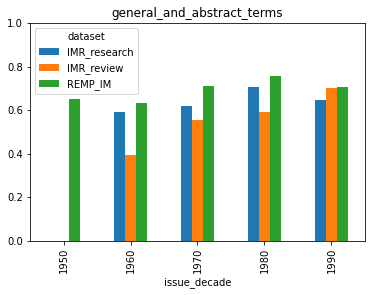

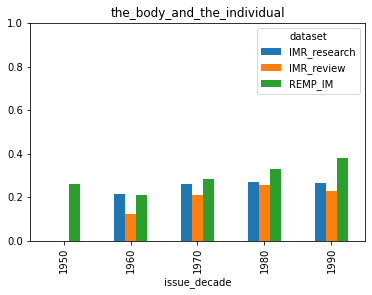

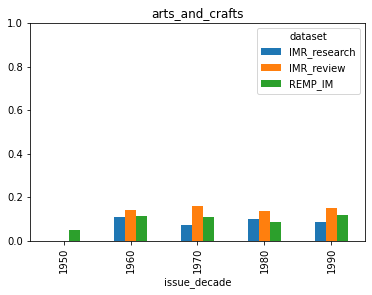

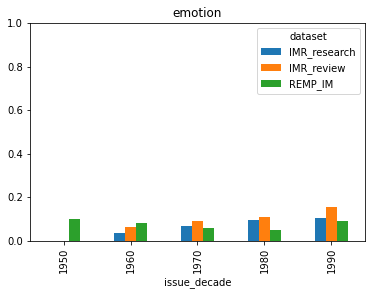

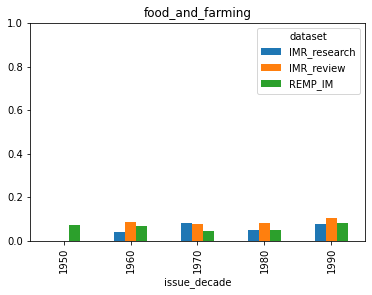

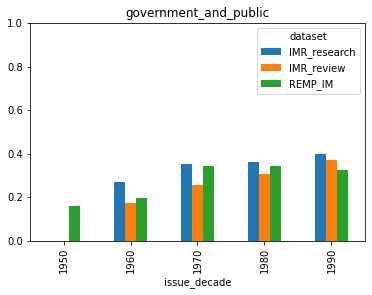

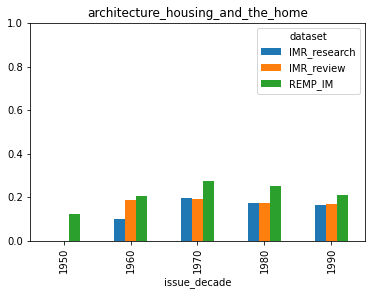

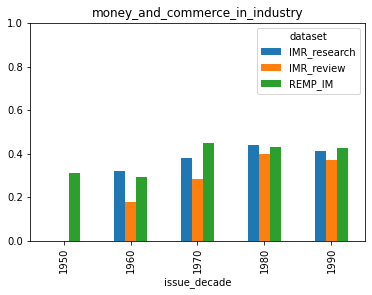

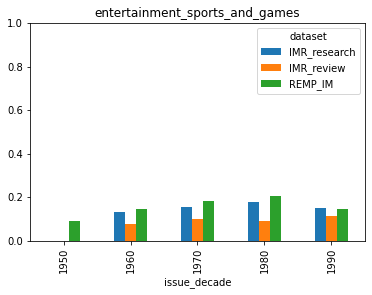

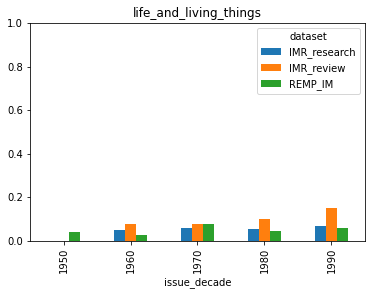

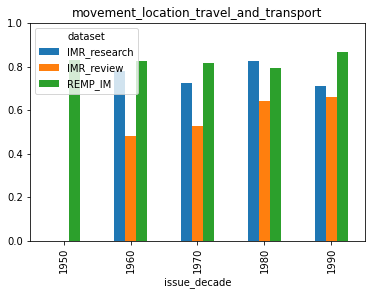

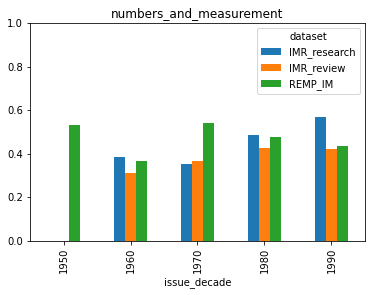

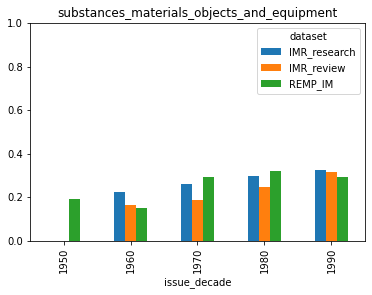

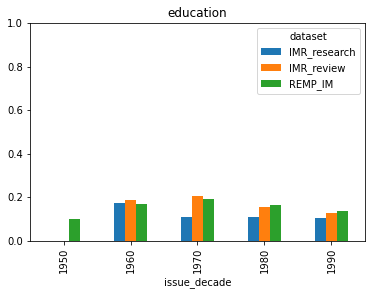

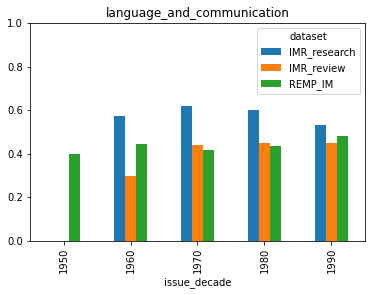

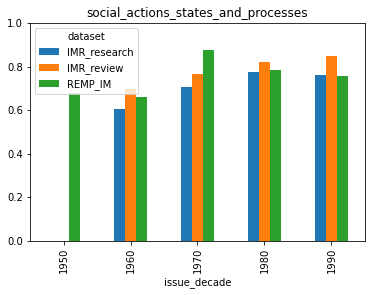

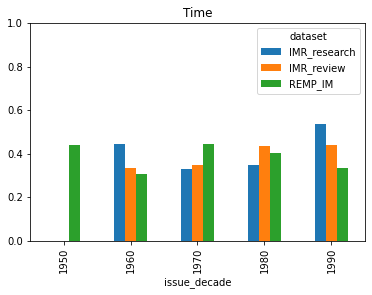

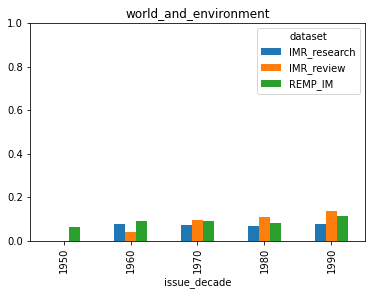

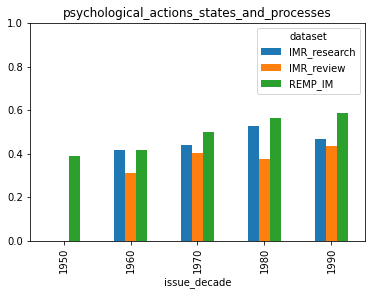

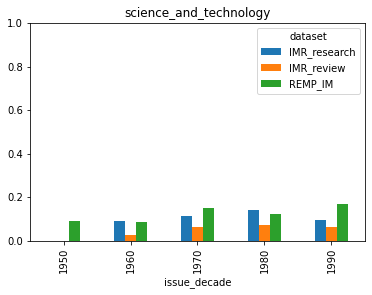

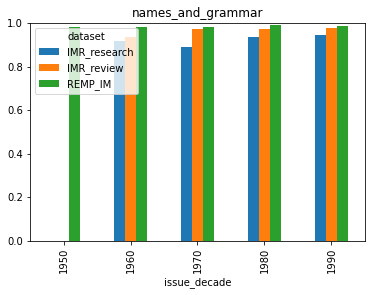

In [132]:
for label in general_labels:
    clean_label = label.replace(' ', '_').replace(',', '')
    #clean_label = 'social_actions_states_and_processes'
    g = df[['dataset', 'issue_decade', clean_label]].groupby(['dataset', 'issue_decade']).sum()
    g['num_pubs'] = df[['dataset', 'issue_decade', clean_label]].groupby(['dataset', 'issue_decade']).size()
    g[clean_label] = g[clean_label] / g.num_pubs
    g.unstack('dataset')[clean_label].plot(kind='bar', title=clean_label, ylim=(0,1))
    #break

g

In [164]:
def parse_usas_code(code, usas_label_map):
    labels = []
    while len(code) > 1:
        if code in usas_label_map:
            labels.append(usas_label_map[code])
        code = code[:-1]
    return labels


usas_label_map = ca.get_usas_label_map()

for ci, code in enumerate(usas_label_map):
    labels = ca.parse_usas_code(code, usas_label_map)
    print(code, labels)
    if ci == 1000:
        break

A ['General And Abstract Terms']
A1 ['General And Abstract Terms']
A1.1.1 ['General actions / making', 'General And Abstract Terms']
A1.1.1- ['Inaction', 'General actions / making', 'General And Abstract Terms']
A1.1.2 ['Damaging and destroying', 'General And Abstract Terms']
A1.1.2- ['Fixing and mending', 'Damaging and destroying', 'General And Abstract Terms']
A1.2 ['Suitability', 'General And Abstract Terms']
A1.2+ ['Suitable', 'Suitability', 'General And Abstract Terms']
A1.2- ['Unsuitable', 'Suitability', 'General And Abstract Terms']
A1.3 ['Caution', 'General And Abstract Terms']
A1.3+ ['Cautious', 'Caution', 'General And Abstract Terms']
A1.3- ['No caution', 'Caution', 'General And Abstract Terms']
A1.4 ['Chance, luck', 'General And Abstract Terms']
A1.4+ ['Lucky', 'Chance, luck', 'General And Abstract Terms']
A1.4- ['Unlucky', 'Chance, luck', 'General And Abstract Terms']
A1.5 ['Use', 'General And Abstract Terms']
A1.5.1 ['Using', 'Use', 'General And Abstract Terms']
A1.5.1+ ['

In [166]:
line_data = ca.get_usas_line_data()


In [175]:
import json

titles_usas_data = []
for line in line_data:
    words = [word_data['word'] for word_data in line_data[line]]
    for word_data in line_data[line]:
        if 'line' in word_data:
            del word_data['line']
        if 'code' in word_data:
            del word_data['code']
    title_usas_data = {
        'title': ' '.join(words),
        'word_data': line_data[line]
    }
    titles_usas_data.append(title_usas_data)
    break

with open('../data/main-review-article-titles-ucrel-usas.json', 'wt') as fh:
    json.dump(titles_usas_data, fh)

In [159]:
usas_label_map

{'A1': 'General And Abstract Terms',
 'A1.1.1': 'General actions / making',
 'A1.1.1-': 'Inaction',
 'A1.1.2': 'Damaging and destroying',
 'A1.1.2-': 'Fixing and mending',
 'A1.2': 'Suitability',
 'A1.2+': 'Suitable',
 'A1.2-': 'Unsuitable',
 'A1.3': 'Caution',
 'A1.3+': 'Cautious',
 'A1.3-': 'No caution',
 'A1.4': 'Chance, luck',
 'A1.4+': 'Lucky',
 'A1.4-': 'Unlucky',
 'A1.5': 'Use',
 'A1.5.1': 'Using',
 'A1.5.1+': 'Used',
 'A1.5.1-': 'Unused',
 'A1.5.2': 'Usefulness',
 'A1.5.2+': 'Useful',
 'A1.5.2-': 'Useless',
 'A1.6': 'Concrete/Abstract',
 'A1.7+': 'Constraint',
 'A1.7-': 'No constraint',
 'A1.8+': 'Inclusion',
 'A1.8-': 'Exclusion',
 'A1.9': 'Avoiding',
 'A1.9-': 'Unavoidable',
 'A2': 'Affect',
 'A2.1': 'Modify, change',
 'A2.1+': 'Change',
 'A2.1-': 'No change',
 'A2.2': 'Cause&Effect/Connection',
 'A2.2+': 'Cause/Effect/Connected',
 'A2.2-': 'Unconnected',
 'A3': 'Being',
 'A3+': 'Existing',
 'A3-': 'Non-existing',
 'A4': 'Classification',
 'A4.1': 'Generally kinds, groups, ex